In [ ]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, GRU,Reshape, Dense
from numpy import array
import tensorflow as tf
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Sep  6 13:36:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
dataset = pd.read_excel("/content/drive/My Drive/Covid_Dataset.xlsx")
dataset

,dateRep,cases,deaths,countriesAndTerritories,Population Density 2020 (P/KM2),continentExp,Wind Speed Minimum,Wind Speed Maximum,Wind Speed Median,Wind Speed Variance
0,2019-12-31,0,0,India,464,Asia,0.4,2.2,1.7,3.58
1,2020-01-01,0,0,India,464,Asia,0.5,2.6,0.8,4.89
2,2020-01-02,0,0,India,464,Asia,0.5,1.6,0.7,1.40
3,2020-01-03,0,0,India,464,Asia,0.1,9.9,0.9,20.86
4,2020-01-04,0,0,India,464,Asia,0.1,11.8,0.8,20.96
...,...,...,...,...,...,...,...,...,...,...
1387,2020-12-10,220025,3124,United_States_of_America,36,America,0.1,18.0,3.8,114.01
1388,2020-12-11,224680,2748,United_States_of_America,36,America,0.1,12.0,2.5,51.39
1389,2020-12-12,234633,3343,United_States_of_America,36,America,0.1,8.5,2.5,25.50
1390,2020-12-13,216017,2315,United_States_of_America,36,America,0.8,15.0,3.6,77.38


**This part is just for the confirmed cases**

In [ ]:
new_index = dataset.iloc[:,0]
new_index
values = dataset.set_index(new_index)
values = values.iloc[:,1:]
values = values.iloc[:1500,0:2].astype('float32')
values
labels = dataset.iloc[:1500,-9]
labels

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(values, labels, test_size=0.20, random_state=88)

In [ ]:
train_labels = pd.array(train_labels)
test_labels = pd.array(test_labels)

In [ ]:
train = train_data
scalers={}
for i in train_data.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_data
for i in test_data.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
def split_series(series, n_past, n_future):
  # n_past ==> no of past observations
  # n_future ==> no of future observations 
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 10
n_future = 20
n_features = 2

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
#LSTM
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(2, activation='tanh',return_state=True) 
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model_LSTM = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_LSTM.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 2), (None, 2 40          input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 2)        0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 20, 2)        40          repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [ ]:
from keras import backend as K

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

#loss test
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy',mean_squared_error])

#optimizer test
#model_LSTM.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])

history_LSTM = model_LSTM.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=25,verbose=1,callbacks=[reduce_lr])

Epoch 1/100
44/44 [==============================] - 5s 34ms/step - loss: 0.7146 - accuracy: 0.4565 - mean_squared_error: 0.7146 - val_loss: 0.6454 - val_accuracy: 0.4138 - val_mean_squared_error: 0.6454
Epoch 2/100
44/44 [==============================] - 1s 15ms/step - loss: 0.5786 - accuracy: 0.4565 - mean_squared_error: 0.5786 - val_loss: 0.5133 - val_accuracy: 0.4138 - val_mean_squared_error: 0.5133
Epoch 3/100
44/44 [==============================] - 1s 15ms/step - loss: 0.4425 - accuracy: 0.4565 - mean_squared_error: 0.4425 - val_loss: 0.3642 - val_accuracy: 0.4138 - val_mean_squared_error: 0.3642
Epoch 4/100
44/44 [==============================] - 1s 16ms/step - loss: 0.2931 - accuracy: 0.4567 - mean_squared_error: 0.2931 - val_loss: 0.2159 - val_accuracy: 0.4190 - val_mean_squared_error: 0.2159
Epoch 5/100
44/44 [==============================] - 1s 15ms/step - loss: 0.1716 - accuracy: 0.4591 - mean_squared_error: 0.1716 - val_loss: 0.1228 - val_accuracy: 0.4438 - val_mean_sq

In [ ]:
from sklearn.metrics import mean_squared_error
loss, accuracy,mean_squared_error = model_LSTM.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % accuracy)
print('Error Rate: %f' % (1 - accuracy))
print('Mean Squared Error: %f' % mean_squared_error)

Accuracy: 0.582800
Error Rate: 0.417200
Mean Squared Error: 0.058801


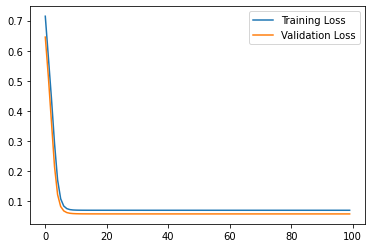

In [ ]:
pred_LSTM=model_LSTM.predict(X_test)
#LSTM
plt.plot(history_LSTM.history["loss"], label="Training Loss")
plt.plot(history_LSTM.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
# GRU
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.GRU(2,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.GRU(2, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.GRU(2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.GRU(2, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_GRU = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_GRU.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 10, 2), (Non 36          input_2[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 2), (None, 2 36          gru[0][0]                        
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 2)        0           gru_1[0][0]                      
____________________________________________________________________________________________

In [ ]:
model_GRU.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy','mean_squared_error'])
history_GRU = model_GRU.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=25,verbose=1,callbacks=[reduce_lr])

Epoch 1/100


ValueError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error
loss, accuracy,mean_squared_error = model_GRU.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % accuracy)
print('Error Rate: %f' % (1 - accuracy))
print('Mean Squared Error: %f' % mean_squared_error)

Accuracy: 0.555200
Error Rate: 0.444800
Mean Squared Error: 0.060049


In [ ]:
new_index = dataset.iloc[:,0]
new_index
values = dataset.set_index(new_index)
values = values.iloc[:,1:]
values = values.iloc[:1500,[0,1,3,5,6,7,8]].astype('float32')
values
labels = dataset.iloc[:1500,-9]
labels

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(values, labels, test_size=0.20, random_state=88)

In [ ]:
train_labels = pd.array(train_labels)
test_labels = pd.array(test_labels)

In [ ]:
train = train_data
scalers={}
for i in train_data.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_data
for i in test_data.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
def split_series(series, n_past, n_future):
  # n_past ==> no of past observations
  # n_future ==> no of future observations 
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 10
n_future = 20
n_features = 7

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
#LSTM
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(2, activation='tanh',return_state=True) 
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model_LSTM = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_LSTM.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 2), (None, 2 80          input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 20, 2)        0           lstm_2[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 20, 2)        40          repeat_vector_2[0][0]            
                                                                 lstm_2[0][1]               

In [ ]:
from keras import backend as K

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

#loss test
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy',mean_squared_error])

#optimizer test
#model_LSTM.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])

history_LSTM = model_LSTM.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=25,verbose=1,callbacks=[reduce_lr])

Epoch 1/100
42/44 [===========================>..] - ETA: 0s - loss: 0.1235 - accuracy: 0.6930 - mean_squared_error: 0.1235

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f8164f57b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


44/44 [==============================] - 63s 1s/step - loss: 0.1237 - accuracy: 0.6934 - mean_squared_error: 0.1237 - val_loss: 0.1366 - val_accuracy: 0.6934 - val_mean_squared_error: 0.1366
Epoch 2/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1236 - accuracy: 0.6934 - mean_squared_error: 0.1236 - val_loss: 0.1363 - val_accuracy: 0.6934 - val_mean_squared_error: 0.1363
Epoch 3/100
44/44 [==============================] - 1s 15ms/step - loss: 0.1236 - accuracy: 0.6934 - mean_squared_error: 0.1236 - val_loss: 0.1364 - val_accuracy: 0.6934 - val_mean_squared_error: 0.1364
Epoch 4/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1236 - accuracy: 0.6934 - mean_squared_error: 0.1236 - val_loss: 0.1364 - val_accuracy: 0.6934 - val_mean_squared_error: 0.1364
Epoch 5/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1236 - accuracy: 0.6934 - mean_squared_error: 0.1236 - val_loss: 0.1364 - val_accuracy: 0.6934 - val_mean_squared_error: 

In [ ]:
from sklearn.metrics import mean_squared_error
loss, accuracy,mean_squared_error = model_LSTM.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % accuracy)
print('Error Rate: %f' % (1 - accuracy))
print('Mean Squared Error: %f' % mean_squared_error)

Accuracy: 0.693400
Error Rate: 0.306600
Mean Squared Error: 0.155395
